In [ ]:
from modelzipper.tutils import *
import matplotlib.pyplot as plt
import numpy as np
import os
from pprint import pprint
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# nltk.download('punkt')
# nltk.download('stopwords')

# 英文停用词
stop_words = set(stopwords.words('english'))

# file_dir = "/data/zecheng/acl2025/MyRLHF/reetrievalheaddetect/analysis/information_flow/Meta-Llama-3.1-8B-Instruct/5900"
file_dir = "/data/zecheng/acl2025/MyRLHF/reetrievalheaddetect/analysis/information_flow/Meta-Llama-3.1-8B-Instruct/5900/ce"
all_files = auto_read_dir(file_dir, file_prefix="3-hop-yes-test*")
all_files = [os.path.join(file_dir, x) for x in all_files]

In [2]:
def plot_layer_data(layer_data, save_path=None, caption=None):
    # 提取数据
    layer_scores, layers = [], []
    for layer_idx, layer in layer_data.items():
        if isinstance(layer, dict):
            layer_scores.append(layer['score'])
            layers.append(layer_idx)
    layer_scores = np.array(layer_scores)

    # 为每个层的四个数值分别定义一个系列
    evidence_weight = layer_scores[:, 0]
    full_context_weight = layer_scores[:, 1]
    attack_context_weight = layer_scores[:, 2]
    remaining_context_weight = layer_scores[:, 3]

    # 创建图形
    plt.figure(figsize=(10, 6))

    # 绘制每层的四个权重
    plt.plot(layers, evidence_weight, label='Evidence Context Weight', color='blue', marker='o')
    plt.plot(layers, full_context_weight, label='Full Context Weight', color='green', marker='x')
    plt.plot(layers, attack_context_weight, label='Attack Context Weight', color='red', marker='s')
    plt.plot(layers, remaining_context_weight, label='Remaining Context Weight', color='purple', marker='^')

    # 添加标题和标签
    if caption is None:
        caption = 'Model Layer Characteristics Across Different Contexts'

    plt.title(caption, fontsize=16)
    plt.xlabel('Layer Number', fontsize=12)
    plt.ylabel('Weight Value', fontsize=12)
    plt.legend()

    # 显示图形
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

def plot_layer_data_multiple(data_list, save_path=None, captions=None):
    # 创建5x5的子图
    fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    axs = axs.flatten()  # 将子图数组展平，方便迭代

    for i, layer_data in enumerate(data_list):
        if i >= 25:  # 只绘制前25个数据
            break

        # 提取数据
        layer_scores, layers = [], []
        for layer_idx, layer in layer_data.items():
            if isinstance(layer, dict):
                layer_scores.append(layer['score'])
                layers.append(layer_idx)

        layer_scores = np.array(layer_scores)

        # 为每个层的四个数值分别定义一个系列
        evidence_weight = layer_scores[:, 0]
        full_context_weight = layer_scores[:, 1]
        attack_context_weight = layer_scores[:, 2]
        remaining_context_weight = layer_scores[:, 3]

        # 绘制每层的四个权重
        axs[i].plot(layers, evidence_weight, label='Evidence Context Weight', color='blue', marker='o')
        axs[i].plot(layers, full_context_weight, label='Full Context Weight', color='green', marker='x')
        axs[i].plot(layers, attack_context_weight, label='Attack Context Weight', color='red', marker='s')
        axs[i].plot(layers, remaining_context_weight, label='Remaining Context Weight', color='purple', marker='^')

        # 添加标题和标签
        if captions is None:
            captions = ['Model Layer Characteristics'] * 25
        axs[i].set_title(captions[i], fontsize=10)
        axs[i].set_xlabel('Layer Number', fontsize=8)
        axs[i].set_ylabel('Weight Value', fontsize=8)
        axs[i].legend(fontsize=8)
        axs[i].grid(True)

    # 调整布局
    plt.tight_layout()
    
    # 保存或显示图形
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [3]:
def count_tokens(content):
    s_lst, d_lst = [], []
    for k, v in content.items():
        if isinstance(k, int):
            if k < 16:
                s_lst.extend(v['topk_tokens'])
            else:
                d_lst.extend(v['topk_tokens'])
            s_lst = list(set(s_lst))
            d_lst = list(set(d_lst))
            # s_lst = [word for word in s_lst if word.lower() not in stop_words and word.isalpha()]
            # d_lst = [word for word in d_lst if word.lower() not in stop_words and word.isalpha()]
    return s_lst, d_lst



100%|██████████| 240/240 [00:00<00:00, 6210.83it/s]


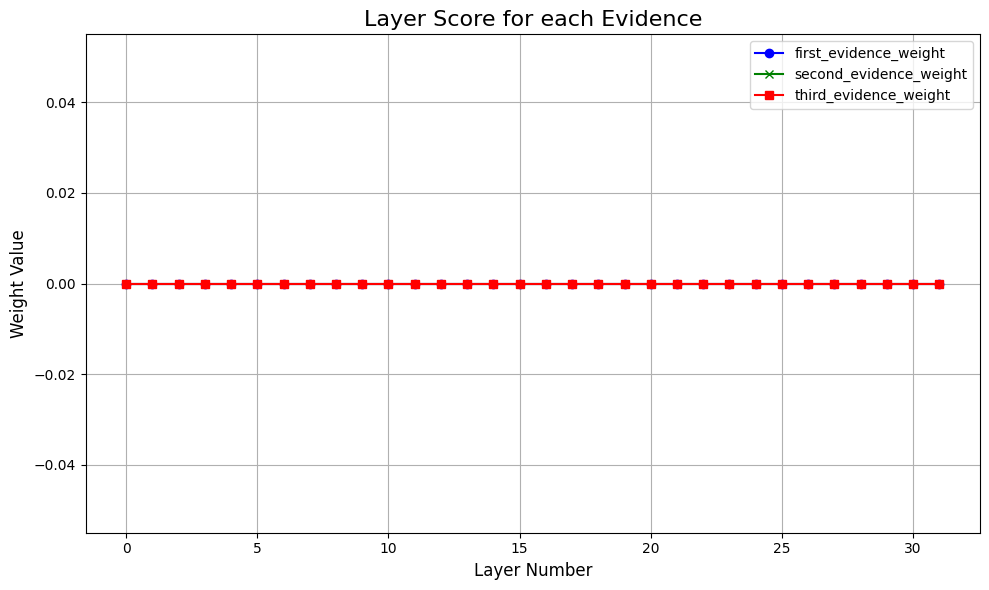

accuracy: 0.4625


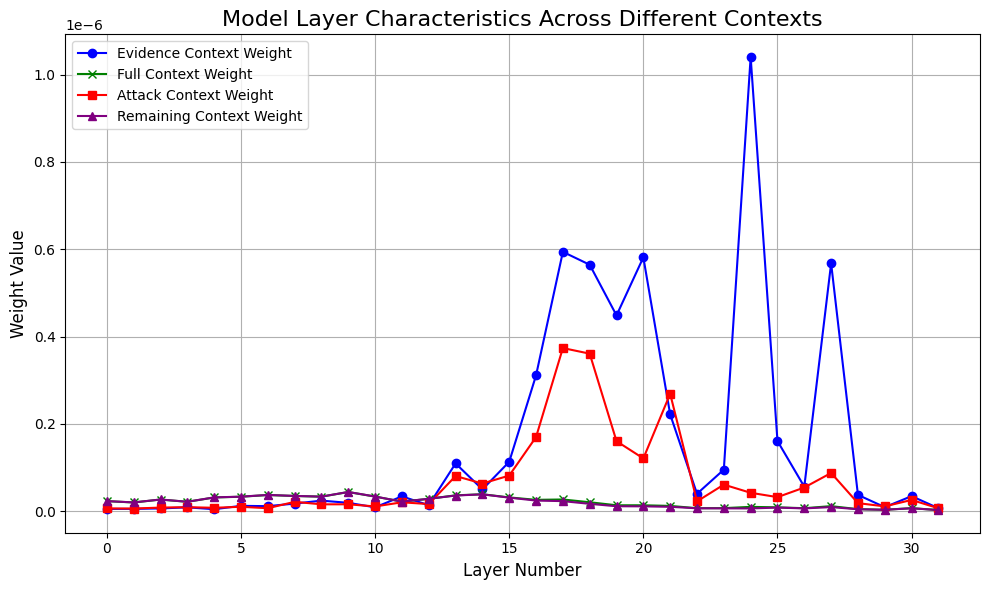

In [15]:
all_predictions = []
labels = []

layers = np.array(list(range(32)))
all_layer_scores = [[0, 0, 0, 0] for i in range(len(layers))]
each_evidence_weight = [[0, 0, 0, 0] for i in range(len(layers))]

for file in tqdm(all_files):
    settings = os.path.basename(file).split("_")
    hop, depth = settings[0], settings[1]
    label = hop.split("-")[-1].lower()
    content = auto_read_data(file)
    if content['score'] == 0:
        all_predictions.append(0)
    else:
        all_predictions.append(1)
    
    # 提取数据
    layer_scores = []
    for layer_idx, layer in content.items():
        if isinstance(layer, dict):
            for i, s in enumerate(layer['score']):
                all_layer_scores[layer_idx][i] += s
            for i, s in enumerate(layer['evidence_proportions']):
                each_evidence_weight[layer_idx][i] += s

for layer_idx, scores in enumerate(all_layer_scores):
    for j, score in enumerate(scores):
        scores[j] = scores[j] / len(all_files)

for layer_idx, scores in enumerate(each_evidence_weight):
    for j, score in enumerate(scores):
        scores[j] = scores[j] / len(all_files)

each_evidence_weight = np.array(each_evidence_weight)
first_evidence_weight = each_evidence_weight[:, 0]
second_evidence_weight = each_evidence_weight[:, 1]
third_evidence_weight = each_evidence_weight[:, 2]
# fourth_evidence_weight = each_evidence_weight[:, 3]


plt.figure(figsize=(10, 6))

# 绘制每层的四个权重
plt.plot(layers, first_evidence_weight, label='first_evidence_weight', color='blue', marker='o')
plt.plot(layers, second_evidence_weight, label='second_evidence_weight', color='green', marker='x')
plt.plot(layers, third_evidence_weight, label='third_evidence_weight', color='red', marker='s')
# plt.plot(layers, fourth_evidence_weight, label='fourth_evidence_weight', color='purple', marker='^')

plt.title('Layer Score for each Evidence', fontsize=16)
plt.xlabel('Layer Number', fontsize=12)
plt.ylabel('Weight Value', fontsize=12)
plt.legend()

# 显示图形
plt.grid(True)
plt.tight_layout()
plt.show()

all_layer_scores = np.array(all_layer_scores)
# 为每个层的四个数值分别定义一个系列
evidence_weight = all_layer_scores[:, 0]
full_context_weight = all_layer_scores[:, 1]
attack_context_weight = all_layer_scores[:, 2]
remaining_context_weight = all_layer_scores[:, 3]

print(f"accuracy: {np.mean(all_predictions)}")

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制每层的四个权重
plt.plot(layers, evidence_weight, label='Evidence Context Weight', color='blue', marker='o')
plt.plot(layers, full_context_weight, label='Full Context Weight', color='green', marker='x')
plt.plot(layers, attack_context_weight, label='Attack Context Weight', color='red', marker='s')
plt.plot(layers, remaining_context_weight, label='Remaining Context Weight', color='purple', marker='^')

plt.title('Model Layer Characteristics Across Different Contexts', fontsize=16)
plt.xlabel('Layer Number', fontsize=12)
plt.ylabel('Weight Value', fontsize=12)
plt.legend()

# 显示图形
plt.grid(True)
plt.tight_layout()
plt.show()

/data/zecheng/acl2025/MyRLHF/reetrievalheaddetect/analysis/figure/Meta-Llama-3.1-8B-Instruct/5900 already exists!


 58%|█████▊    | 121/210 [00:12<00:09,  9.88it/s]


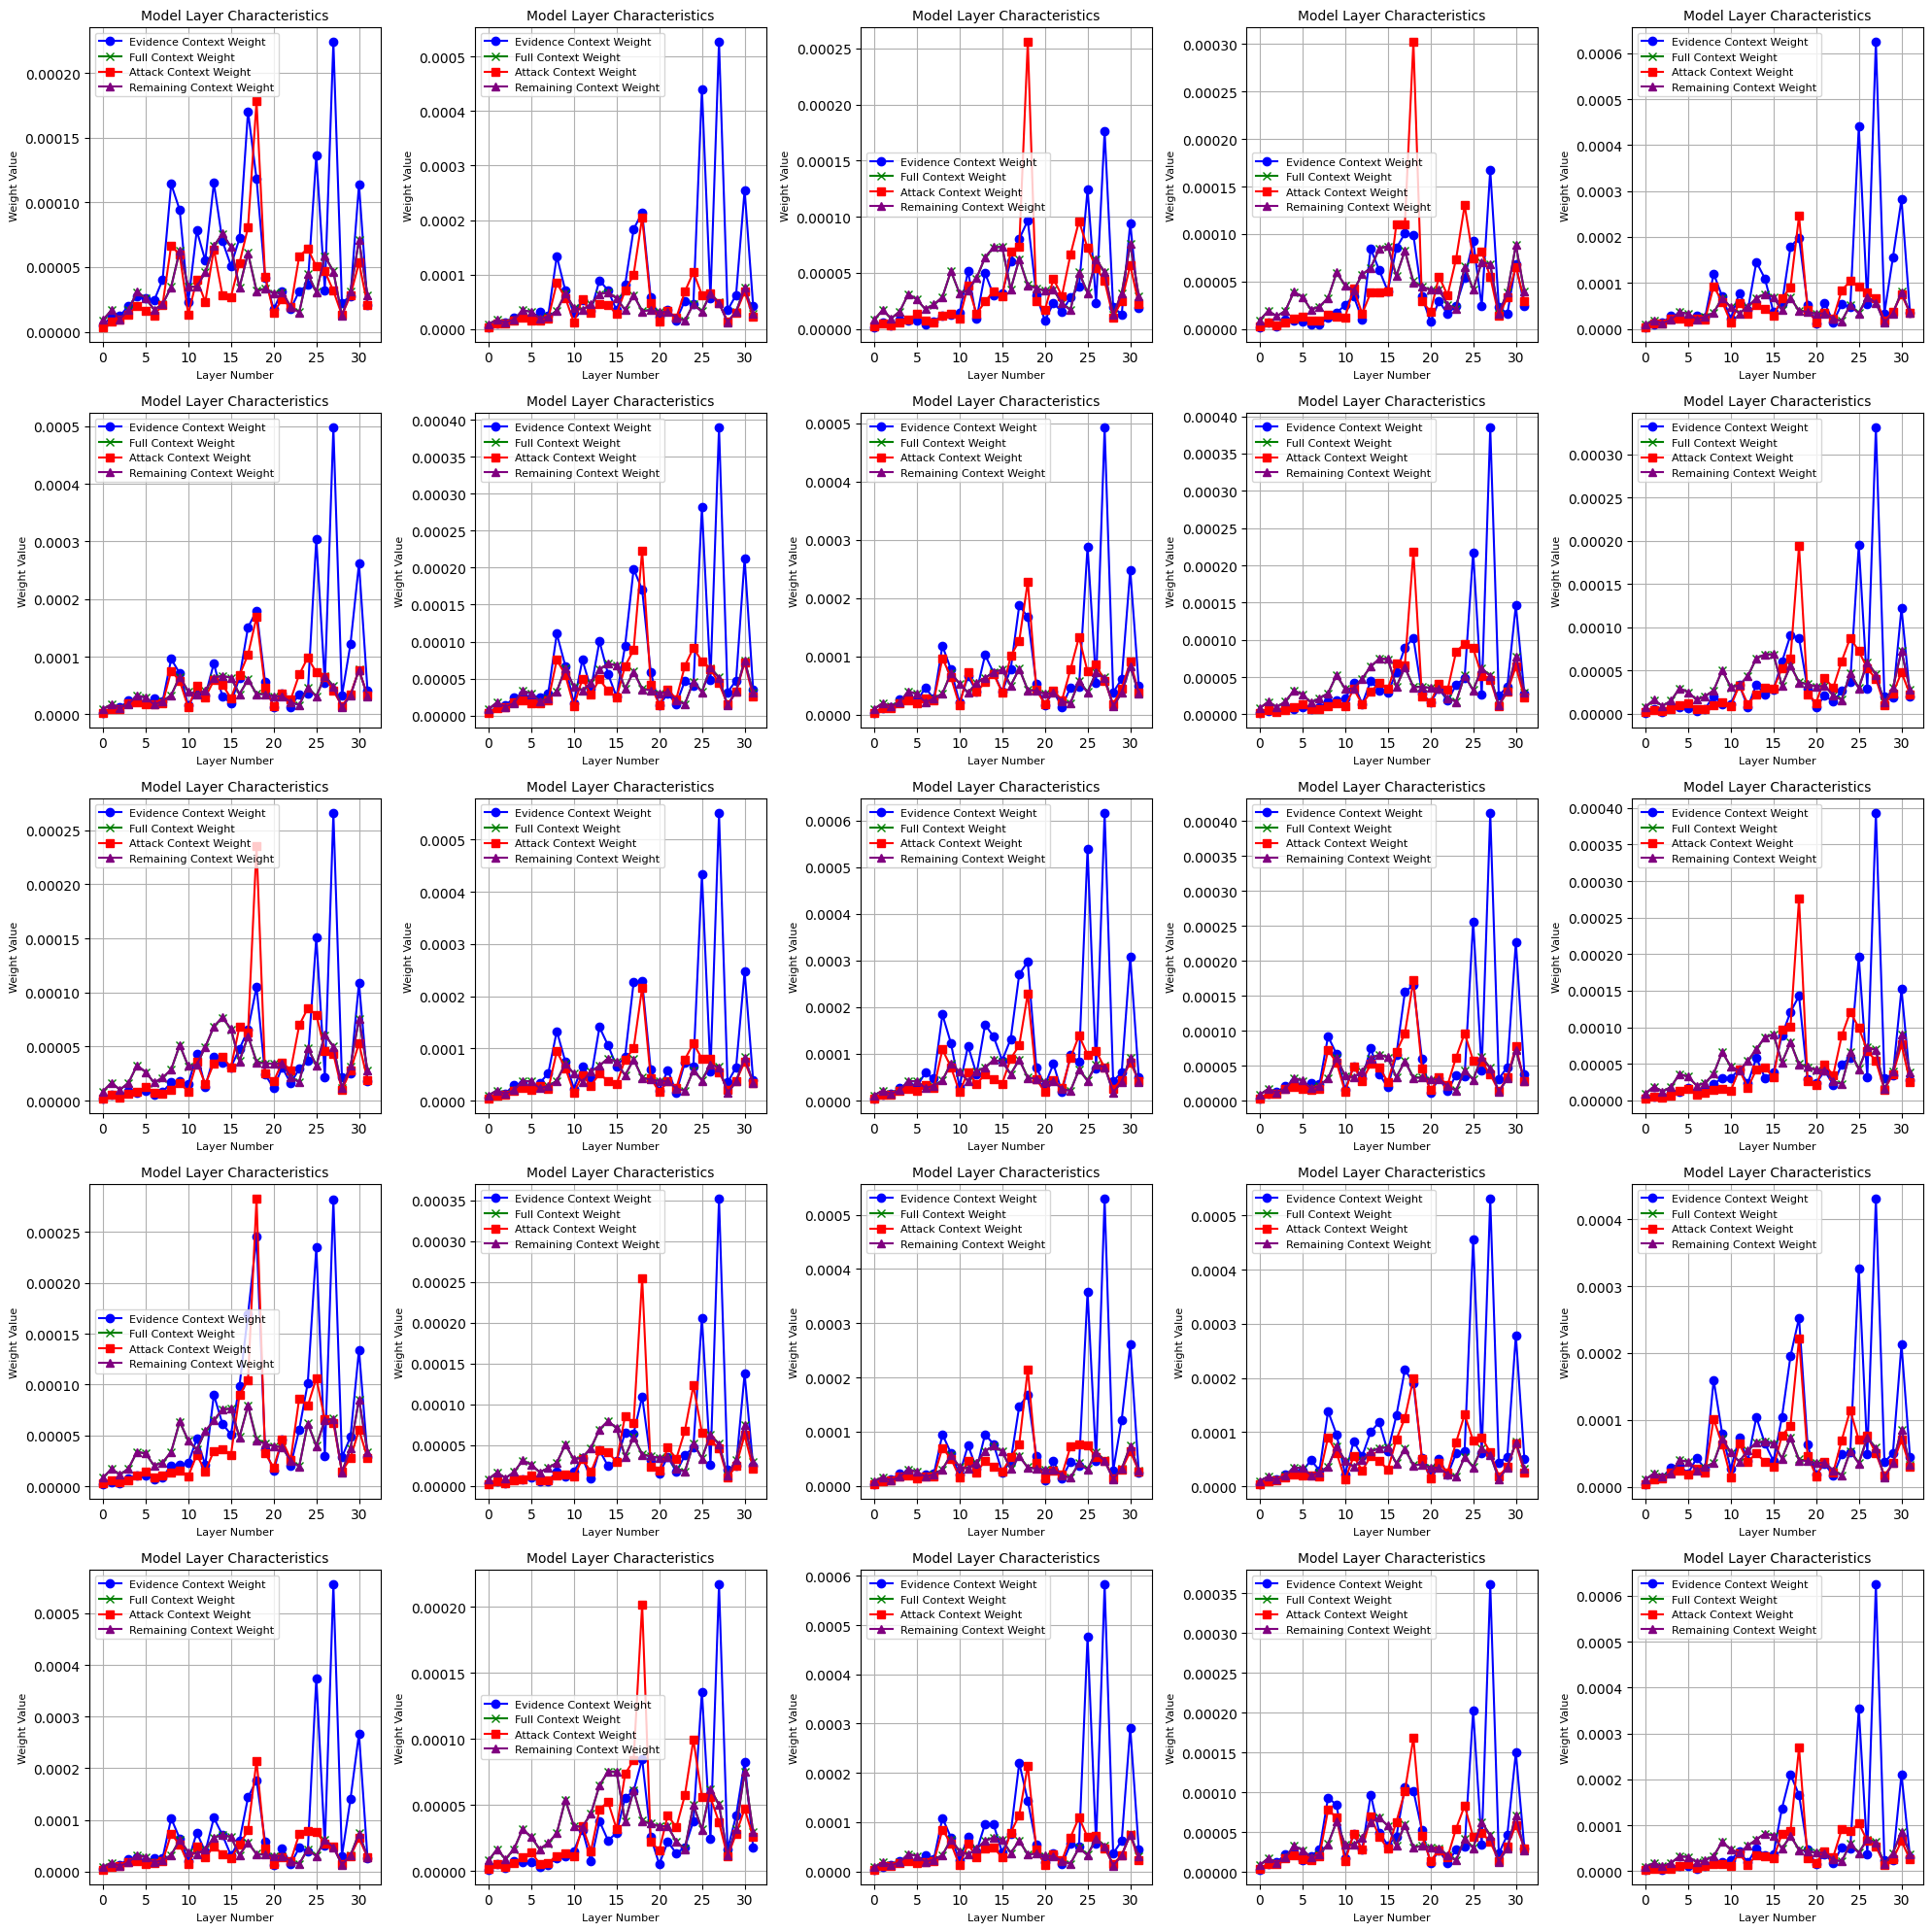

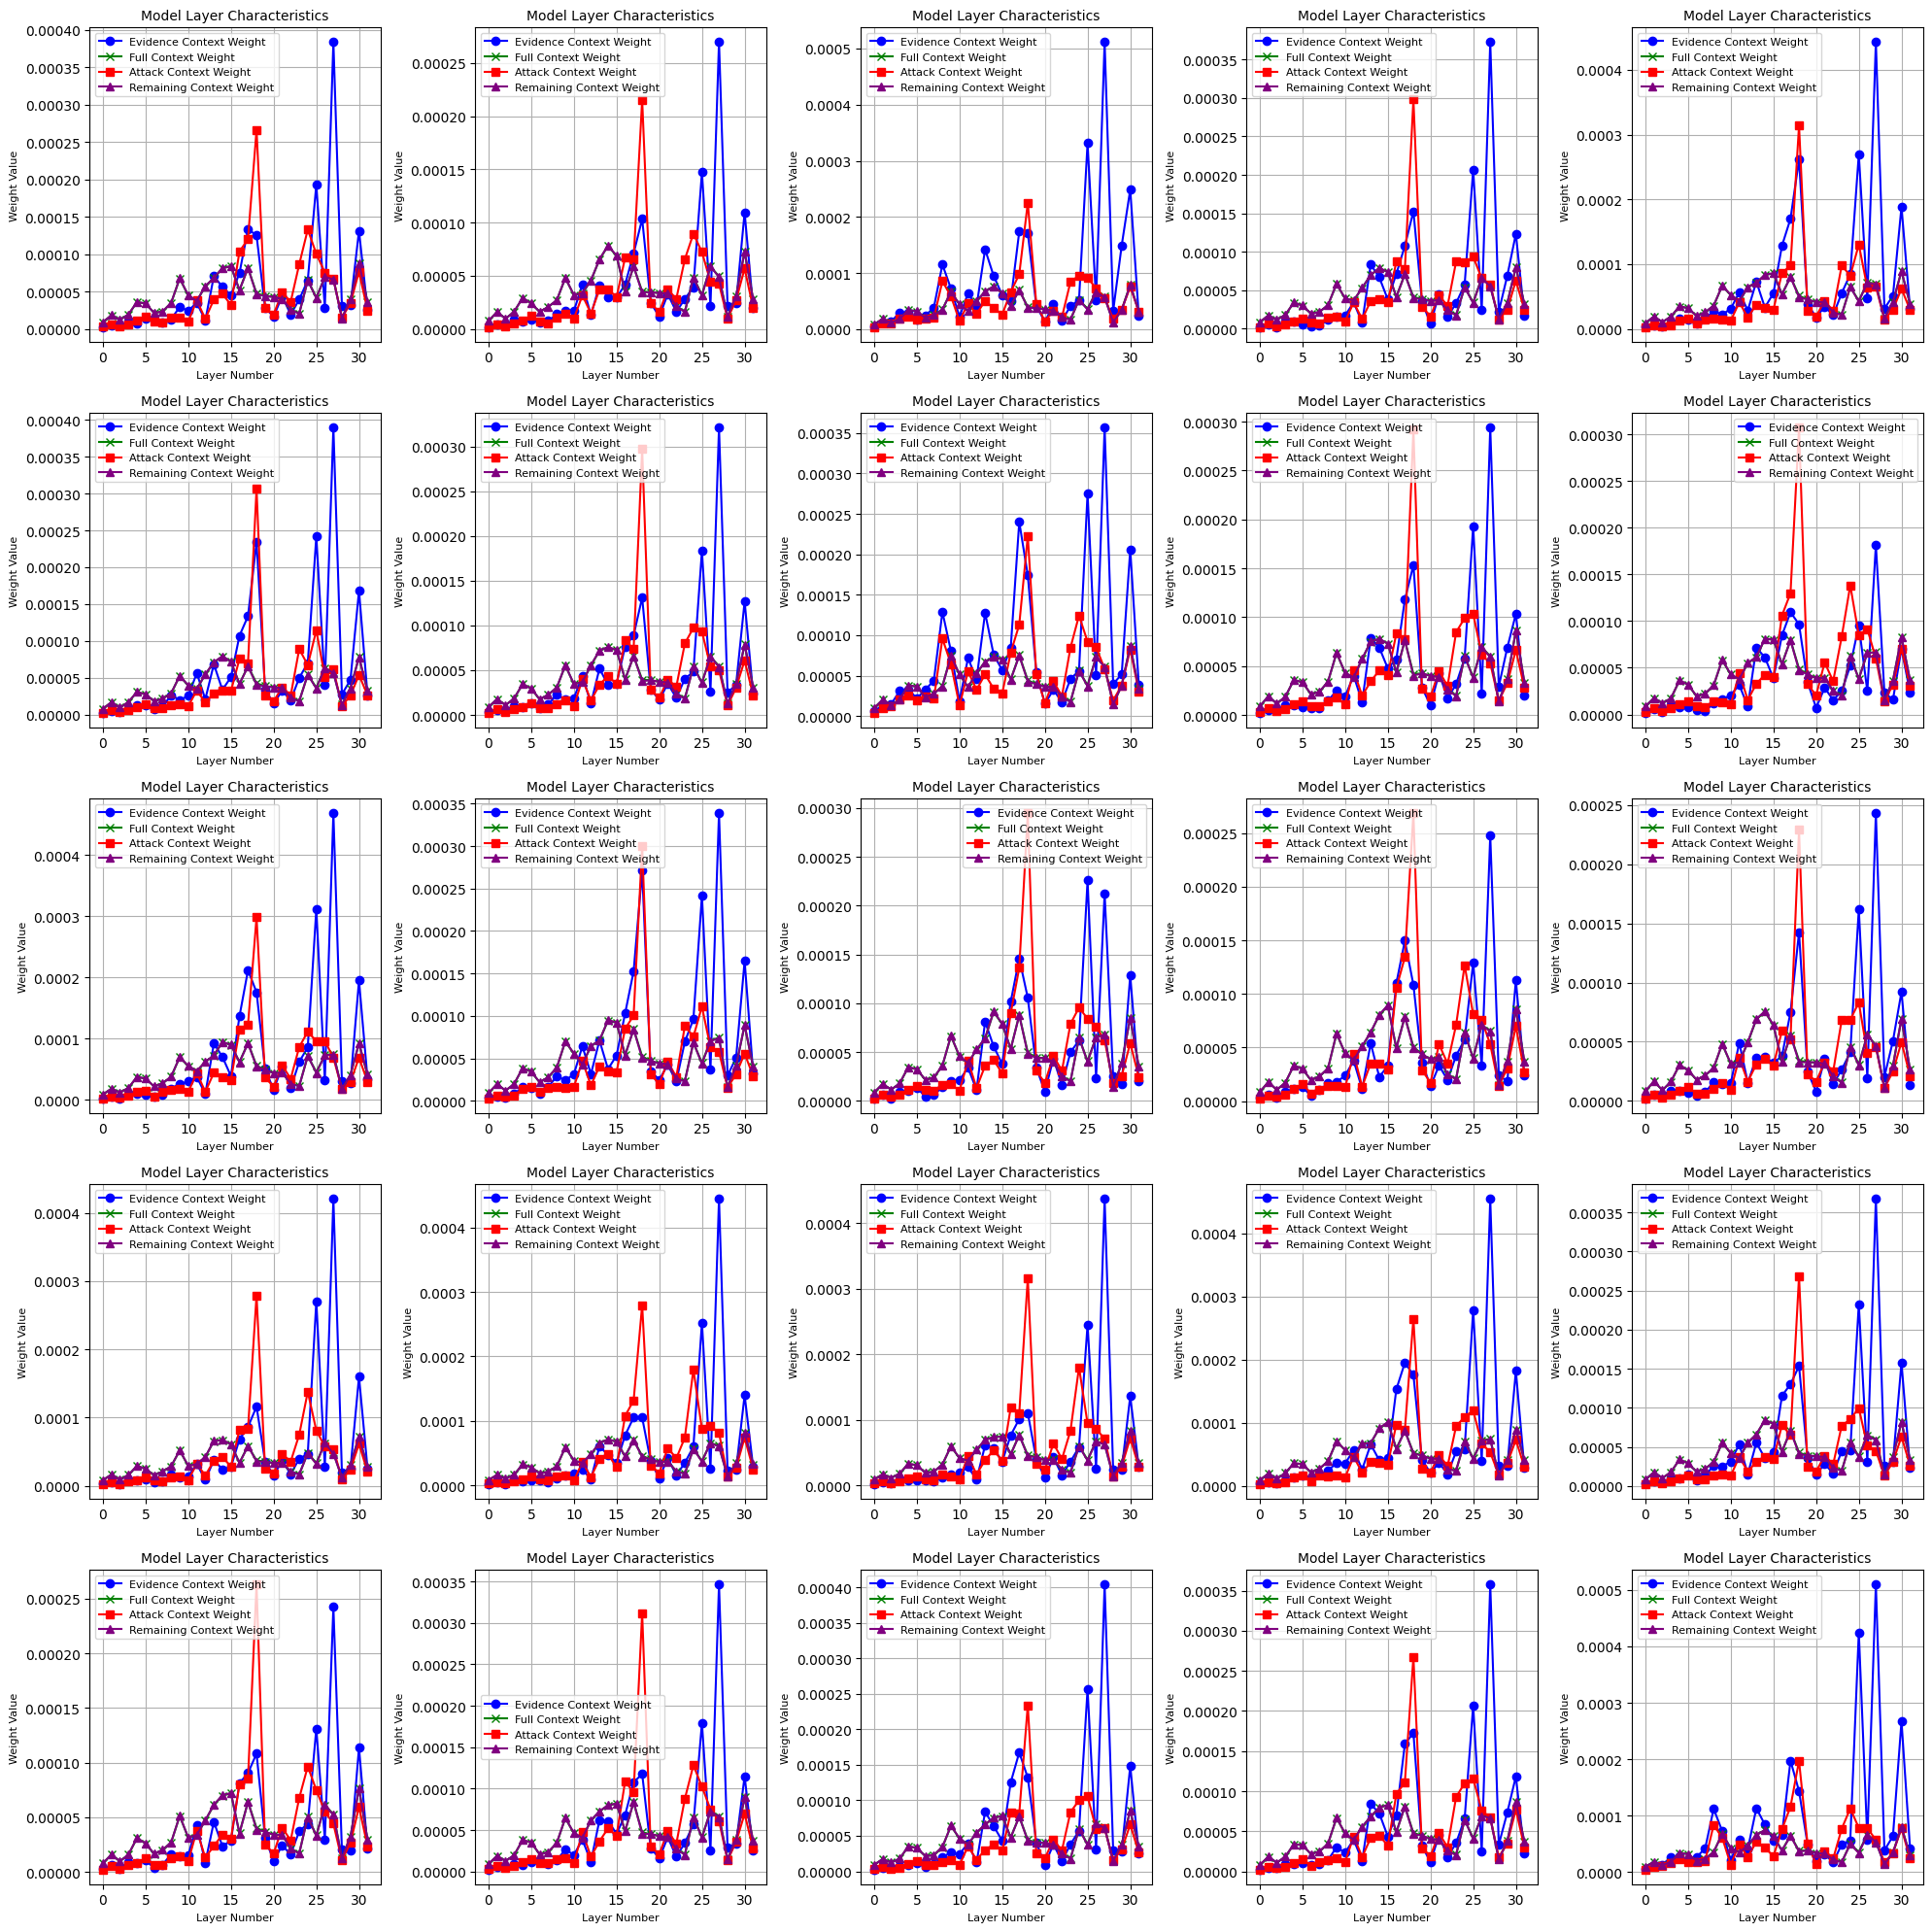

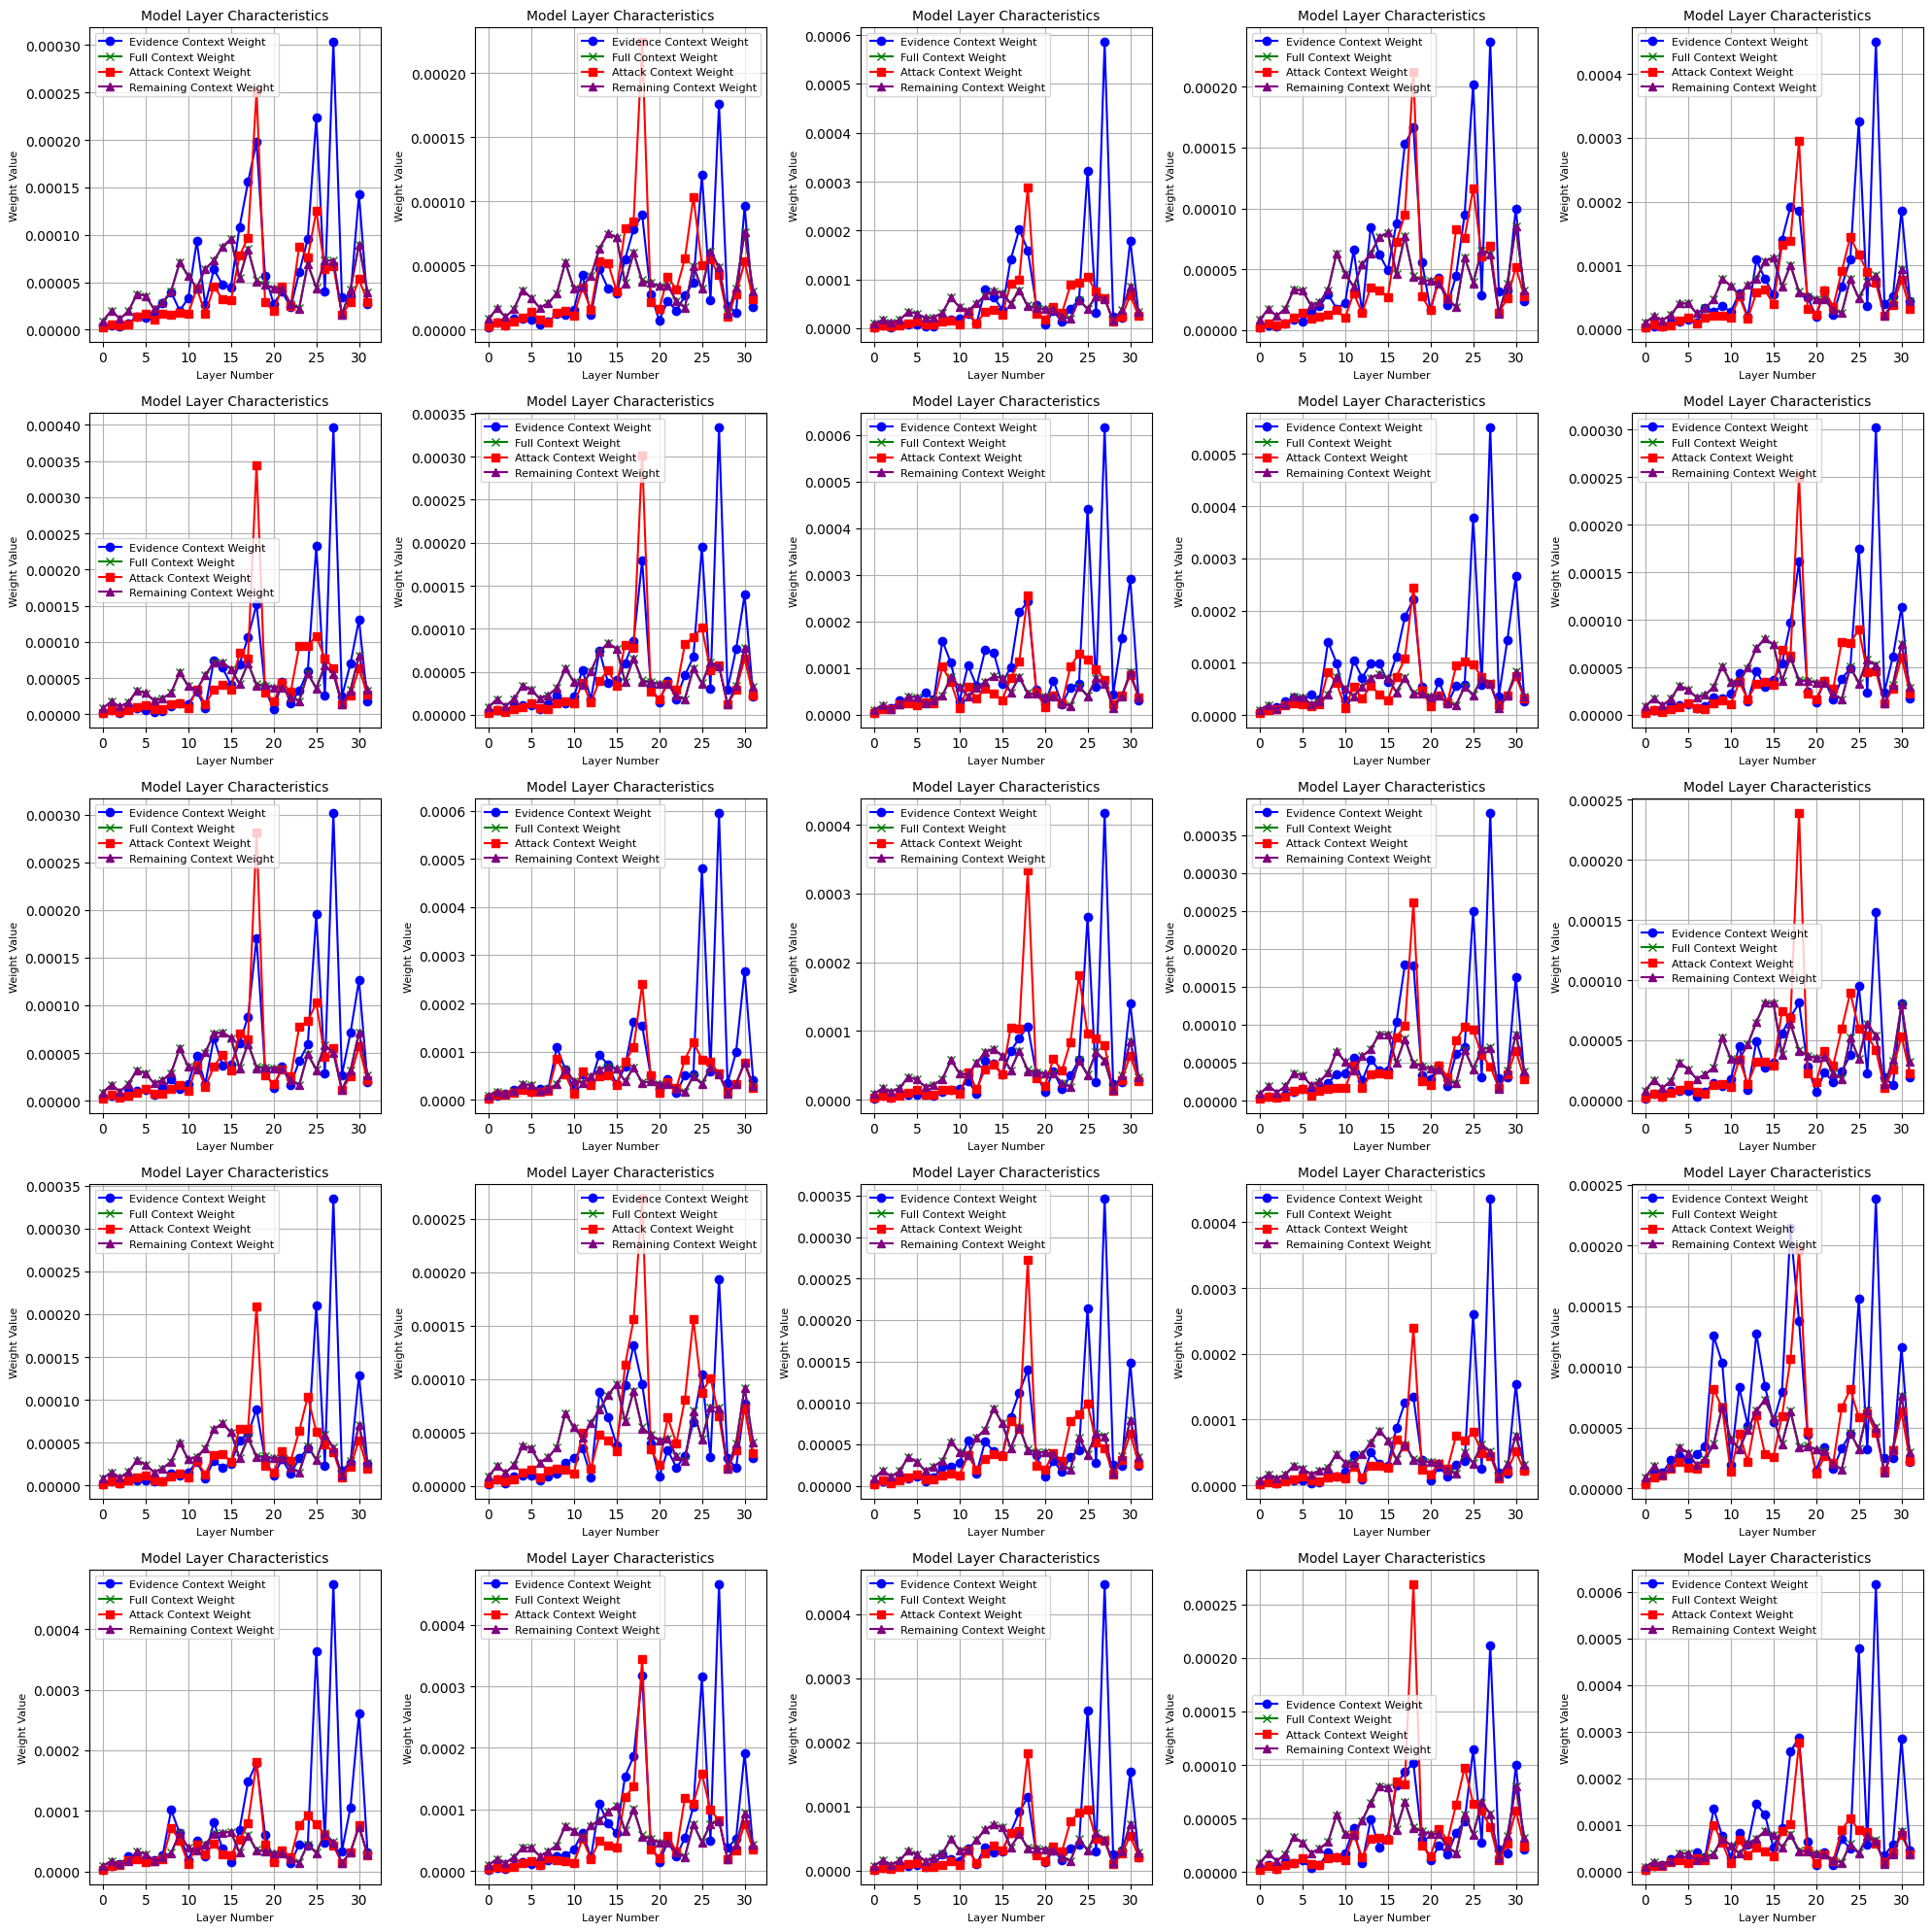

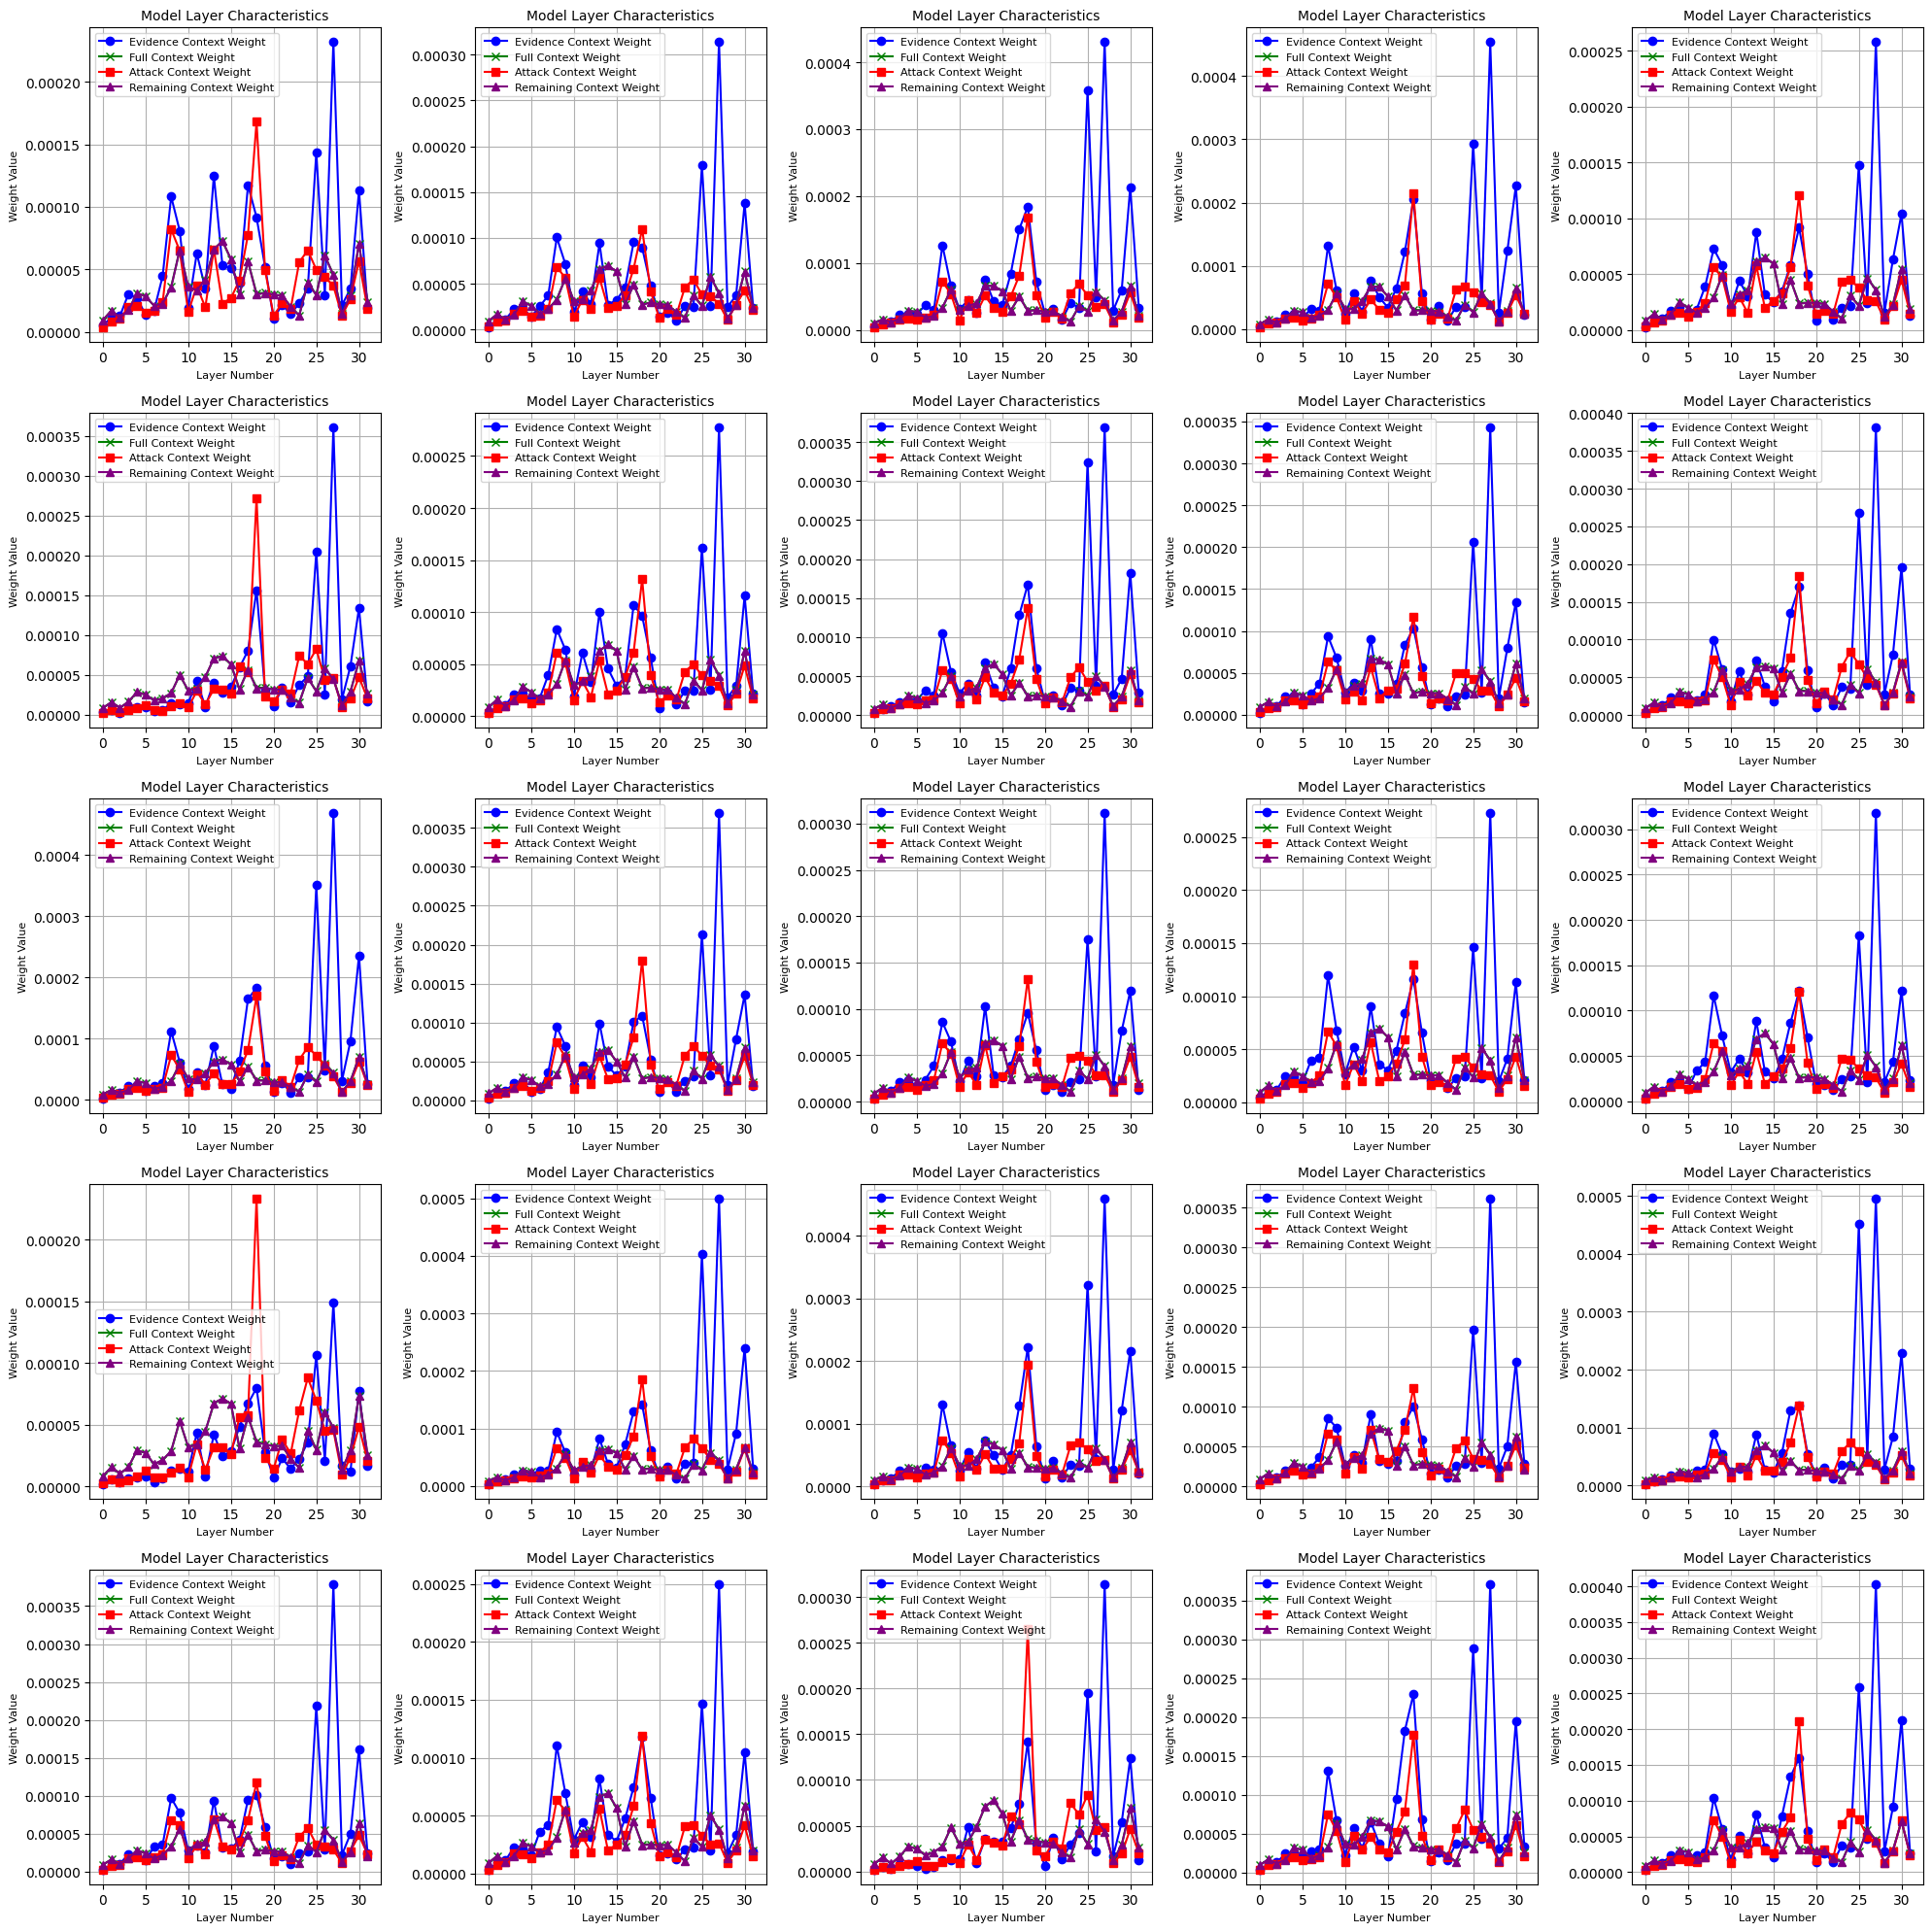

In [15]:
dir_path = "/data/zecheng/acl2025/MyRLHF/reetrievalheaddetect/analysis/figure/Meta-Llama-3.1-8B-Instruct/5900"
auto_mkdir(dir_path)
succ_cache_lst, fail_cache_lst = [], []
succ_idx, fail_idx = 0, 0
f_shallow_layer_topk_tokens, f_deep_layer_topk_tokens = [], []
s_shallow_layer_topk_tokens, s_deep_layer_topk_tokens = [], []

for file in tqdm(all_files):
    settings = os.path.basename(file).split("_")
    hop, depth = settings[0], settings[1]
    label = hop.split("-")[-1].lower()
    content = auto_read_data(file)

    if label in content["pred_res"].lower():
        succ_cache_lst.append(content)
        # save_path = os.path.join(dir_path, f"correct_{hop}_{depth}.png")
        # s_lst, d_lst = count_tokens(content)
        # s_shallow_layer_topk_tokens.extend(s_lst)
        # s_deep_layer_topk_tokens.extend(d_lst)
        # s_shallow_layer_topk_tokens = list(set(s_shallow_layer_topk_tokens))
        # s_deep_layer_topk_tokens = list(set(s_deep_layer_topk_tokens))
    else:
        fail_cache_lst.append(content)
        # save_path = os.path.join(dir_path, f"wrong_{hop}_{depth}.png")
        # f_s_lst, f_d_lst = count_tokens(content)
        # f_shallow_layer_topk_tokens.extend(f_s_lst)
        # f_deep_layer_topk_tokens.extend(f_d_lst)
        # f_shallow_layer_topk_tokens = list(set(f_shallow_layer_topk_tokens))
        # f_deep_layer_topk_tokens = list(set(f_deep_layer_topk_tokens))
    if len(succ_cache_lst) == 25:
        plot_layer_data_multiple(succ_cache_lst, os.path.join(dir_path, f"correct_{hop}_{succ_idx}.png"))
        succ_cache_lst = []
        succ_idx += 1
    if len(fail_cache_lst) == 25:
        plot_layer_data_multiple(fail_cache_lst, os.path.join(dir_path, f"wrong_{hop}_{fail_idx}.png"))
        fail_cache_lst = []
        fail_idx += 1
    
    if succ_idx > 0 and fail_idx > 0:
        break
    # plot_layer_data(content, save_path, settings)

In [ ]:
pprint(s_shallow_layer_topk_tokens)
pprint(s_deep_layer_topk_tokens)

In [ ]:
pprint(f_shallow_layer_topk_tokens)
pprint(f_deep_layer_topk_tokens)

1. 首先按照是否回答正确进行划分

In [ ]:
print(os.path.basename(all_files[0]))
instance = auto_read_data(all_files[0])

print(instance.keys())
topk_tokens = instance[0]['topk_tokens']  # 0 is the layer index
print(topk_tokens)


In [ ]:
instance

In [ ]:
from modelzipper.tutils import *
import matplotlib.pyplot as plt
import numpy as np

# 数据：每层的四个权重数值
layer_data = {
    0: [4.959665238857269e-06, 3.241457776316934e-05, 1.915307207541032e-05, 3.2536576766406514e-05],
    1: [6.113294512033463e-06, 3.588264777170998e-05, 1.875220826177886e-05, 3.602615563138125e-05],
    2: [3.3918768167495728e-06, 3.954556222308137e-05, 1.3849161791078972e-05, 3.973980739152632e-05],
    3: [4.411069676280022e-06, 5.2358093491322196e-05, 8.825382048433477e-06, 5.265427548364616e-05],
    4: [1.409146934747696e-05, 5.386575933844638e-05, 3.642363078666456e-05, 5.403527912603641e-05],
    5: [3.511123359203339e-05, 5.6201644940101574e-05, 3.5292892293496564e-05, 5.633910748514353e-05],
    6: [1.1113425716757775e-05, 7.276903453996061e-05, 2.8178434700803887e-05, 7.310343142066736e-05],
    7: [5.842046812176705e-06, 0.0001060344519507986, 4.455788681904475e-05, 0.0001065330393336028],
    8: [1.1762231588363648e-05, 0.0001127064162164015, 5.673789278124318e-05, 0.00011318438913503663],
    9: [2.7908291667699813e-05, 0.00013008105668458142, 4.593079740350897e-05, 0.00013067705246309438],
    10: [3.418363630771637e-05, 0.0001264135955578132, 5.119948676138213e-05, 0.00012694854421944576],
    11: [1.703500747680664e-05, 0.00011598208717596412, 0.00018443663914998373, 0.00011594746073912442],
    12: [8.40499997138977e-06, 0.00017115683509330904, 6.23587067380096e-05, 0.00017200319697982774],
    13: [0.0006855845451354981, 0.00032301160542711025, 0.0008409402587197044, 0.0003200018249680569],
    14: [0.00020253956317901612, 0.0003778427242573789, 0.0010134717731764822, 0.0003756827718102024],
    15: [6.217481568455696e-05, 0.00031942024437131556, 0.00043356729050477344, 0.0003195906271669796],
    16: [0.013655662536621094, 0.0003536513946724383, 0.001258882609280673, 0.0003170647412450094],
    17: [0.0028010547161102296, 0.00025052682229714346, 0.0014491054144772616, 0.00023932953601892812],
    18: [0.005669236183166504, 0.00029643327858037727, 0.0007366122621478456, 0.0002813514333096739],
    19: [0.0010981798171997071, 0.0001875015840294935, 0.001387981077035268, 0.0001803515607935149],
    20: [0.007794710993766785, 0.0002826679076511171, 0.0023177458029804807, 0.0002557887740868018],
    21: [0.0017806708812713623, 0.00020140549310989484, 0.001226557023597486, 0.0001933175469836189],
    22: [0.001896064169704914, 0.00017294463764580063, 0.0008285483627608328, 0.00016600876801548678],
    23: [0.0013591922819614411, 0.00015825946183714815, 0.0010787226033933234, 0.0001515341972385033],
    24: [0.0015029147267341613, 0.0002128314567774904, 0.001215286637571725, 0.00020555120376496033],
    25: [0.011409810930490493, 0.0002014303863407309, 0.0012002720031887293, 0.0001696389194466929],
    26: [0.0020347237586975098, 0.00016976514241572694, 0.0004434507114417625, 0.00016403680461855895],
    27: [0.002594304084777832, 0.00025047442936777206, 0.0014475617896426809, 0.00023979435073309436],
    28: [0.0008534610271453858, 0.00015710730061251676, 0.0029951467206983857, 0.00014380581997533933],
    29: [0.00024196654558181763, 0.0001313316633156309, 0.0006413843595620358, 0.00012897700992524328],
    30: [0.004878909885883331, 0.00029894708488866395, 0.0019776151713096733, 0.0002807725914574342],
    31: [0.0009814728051424026, 0.0001716352537038241, 0.0005350086386456634, 0.00016815008150651299],
}

